In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('sellers.csv', 'sellers')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Parvathi@45',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/prasanth/Desktop/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing payments.csv
NaN values before replacement:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64



In [2]:
pip install mysql-connector-python

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Parvathi@45",
                             database = "ecommerce")
cur = db.cursor()


In [31]:
query = """select distinct customer_city from customers"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [11]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [17]:
query = """select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,ART,749.44
1,COOL STUFF,15663.87
2,GAMES CONSOLES,9106.44
3,TELEPHONY,23521.39
4,SPORT LEISURE,35383.11
...,...,...
57,CHRISTMAS ARTICLES,152.91
58,DRINKS,196.51
59,CINE PHOTO,228.76
60,FURNITURE,511.74


# Calculate the percentage of orders that were paid in installments.

In [21]:
query = """select (sum(case when payment_installments >1 then 1
else 0 end))/count(*)*100 from payments"""
cur.execute(query)

data = cur.fetchall()
data

[(Decimal('49.4176'),)]

# Count the number of customers from each state.

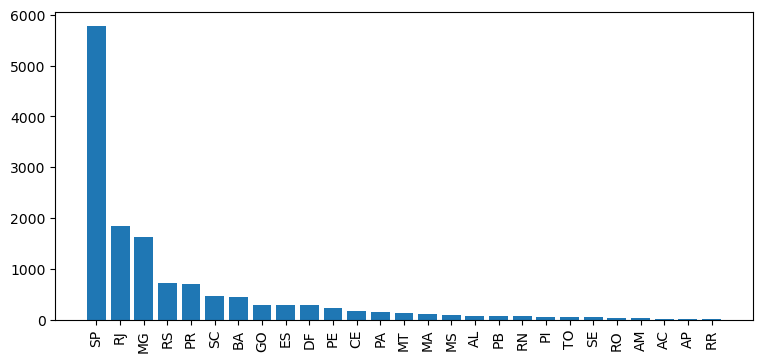

In [30]:
query = """select customer_state, count(customer_id)
from customers group by customer_state"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (9, 4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# 1. Calculate the number of orders per month in 2018.

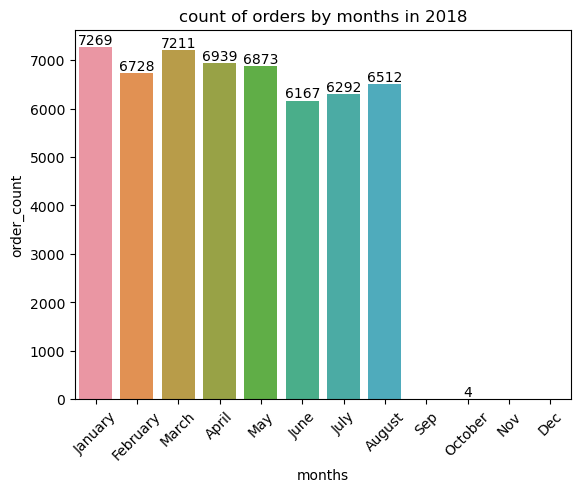

In [58]:
query = """select monthname(order_purchase_timestamp) months, count(order_id)
from orders where year(order_purchase_timestamp) =2018
group by months
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame (data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "Sep", "October", "Nov", "Dec"]
ax = sns.barplot(x = df["months"],y= df["order_count"], data = df, order = o)

plt.xticks(rotation = 45)

ax.bar_label(ax.containers[0])
plt.title("count of orders by months in 2018")
plt.show()


#df = pd.DataFrame(data)
#df.head()

# Find the average number of products per order, grouped by customer city.

In [93]:
query = """with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city", "average product/order"])
df.head(10)

,customer city,average product/order
0,sumare,5.00
1,passo fundo,3.00
2,santo angelo,3.00
3,fortaleza,2.33
4,curitiba,2.00
5,sao caetano do sul,2.00
6,astolfo dutra,2.00
7,nova prata do iguacu,2.00
8,taboao da serra,2.00
9,brusque,2.00


# Calculate the percentage of total revenue contributed by each product category.

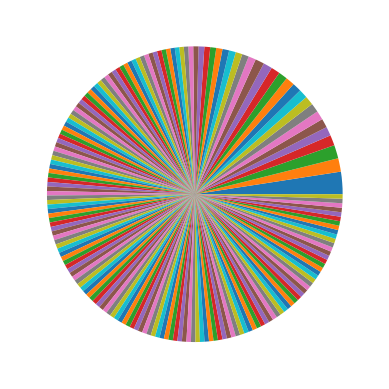

In [99]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)

#data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
plt.pie(df["percentage distribution"])
plt.show()
#df.head(10)

In [102]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,FIXED TELEPHONY,0.69
1,BED TABLE BATH,0.37
2,COMPUTER ACCESSORIES,0.33
3,HEALTH BEAUTY,0.24
4,FURNITURE DECORATION,0.23


#  Identify the correlation between product price and the number of times a product has been purchased.

In [114]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items 
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]
np.corrcoef([arr1,arr2])

#data

array([[ 1.        , -0.15171971],
       [-0.15171971,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue

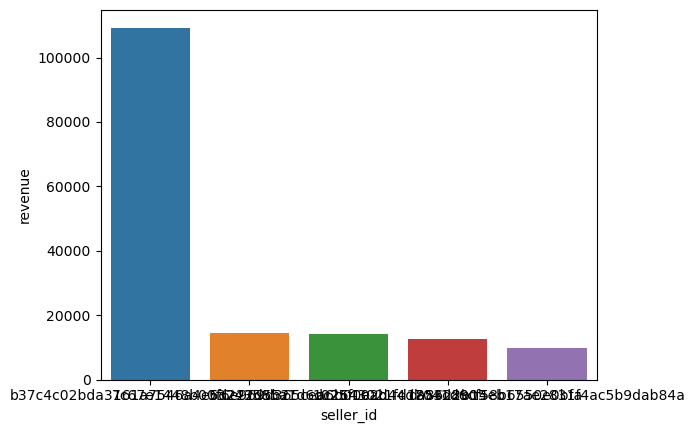

In [123]:
query = """select *, dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, sum(payments.payment_value) 
revenue from order_items join payments 
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head(5)
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.show()